# Day 8 Exercise

### Creating your own recommender engine pool and generating recommendations from a seed track

*A. Individual*
1. Choose your own set of genres to be used as prediction values of the KNN model. You may select among the ones listed above or a completely new one (but you must already have the scraped playlist and tracks data for this new genre) 

2. Choose the features you want to use for the classification. Start by using all and then narrow down by removing one feature at a time and checking if the accuracy increases.

3. Check if the model works by using it to predict genres of the spotify_daily_charts_tracks dataset. Do some spot checks and view the songs classified with the highest probabilities per genre


*B. Groupwork: For your sprint project*

4. Obtain a tracks dataset that is relevant to the client you are targeting. 
   For example:
   
    - A client artist's full discography (hint: use sp.playlist_tracks(ALBUM_ID) for every album of the artist)
    
    - Tracks from a popular playlist in spotify that your client artist appears in
    
    - Discographies of prospect artists to collaborate with 
    
    - Popular tracks of the genre that your client artist is targeting to enter
    
    
5. Using the model you tuned in (A), predict the genres of the tracks in (B.4). 

6. Do some spot checks and view the songs classified with the highest probabilities per genre. 
   What does the predicted classifications reveal about your tracks dataset?
   
*C. Groupwork: For your sprint project*

7. Explore different seed tracks configurations:
    - A single track
    - A *representative track* made by aggregating the audio features and genre probabilities of all tracks in a chosen album/genre
    - A *hypothetical track* with specified desired audio feature values
    
8. For each choice of seed track in, generate using the recommender engine pool you made in (A). As a user, would you listen to the recommended tracks?

9. In addition to (2), check if the top 10 tracks with the **worst** similarity measure (i.e. most dissimilar to the seed track) make sense. As a user, do you agree that these are the tracks to be first discarded from the recommendation pool?



In [118]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score,roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances, cosine_similarity

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

%matplotlib inline

## Part 1. Recommender Engine Pool

### 1. Read the training data

In [119]:
#genre_names = ["R&B", "Classical", "Country", "Electronic", "Hiphop","Jazz", "Pop", "Rock", "Reggae", "Rap"]
genre_names = ["Rock", "Hiphop", "R&B", "Folk", "Indie"]

playlist_df_list = []
track_df_list = []
for genre in genre_names:
    # read and process the playlist data for keyword
    print(genre)
    pdf = pd.read_csv('data/'+genre.lower()+'_playlist_data.csv')
    pdf['genre'] = genre.lower().replace('&','n')
    playlist_df_list.append(pdf)

    tdf = pd.read_csv('data/'+genre.lower()+'_playlist_tracks_data.csv')
    tdf['genre'] = genre.lower().replace('&','n')
    tdf = tdf.drop(columns=['playlist_name'])
    tdf = tdf.merge(pdf[['playlist_id','playlist_name']], on=['playlist_id'], how='left')
    
    track_df_list.append(tdf)
    
    
        
playlist_df = pd.concat(playlist_df_list)
tracks_df = pd.concat(track_df_list)


Rock
Hiphop
R&B
Folk
Indie


In [120]:
tracks_df['genre'].value_counts()

rock      2134
folk      1865
indie     1774
hiphop    1548
rnb       1508
Name: genre, dtype: int64

In [121]:
#check shape
playlist_df.shape, tracks_df.shape

((342, 7), (8829, 22))

In [122]:
#check columns
print("Playlist dataset columns: %s \n" % playlist_df.columns.values)
print("Tracks dataset columns: %s" % tracks_df.columns.values)

Playlist dataset columns: ['playlist_id' 'playlist_name' 'playlist_total_tracks' 'owner_id'
 'owner_name' 'total_followers' 'genre'] 

Tracks dataset columns: ['track_id' 'track_name' 'artist_id' 'artist_name' 'album_id' 'duration'
 'release_date' 'popularity' 'danceability' 'energy' 'key' 'loudness'
 'mode' 'speechiness' 'acousticness' 'instrumentalness' 'liveness'
 'valence' 'tempo' 'playlist_id' 'genre' 'playlist_name']


In [123]:
#check null rows
playlist_df[playlist_df.isnull().any(1)]
#tracks_df[tracks_df.isnull().any(1)]


,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre


In [124]:
#remove null rows
tracks_df = tracks_df[~tracks_df.isnull().any(1)]
tracks_df.shape

(8829, 22)

In [125]:
# How many unique tracks are in the combined dataset?
len(tracks_df['track_id'].unique())

8482

In [126]:
#retain only distinct tracks per keyword
tracks_df =tracks_df.drop_duplicates(subset='track_id')
tracks_df.shape

(8482, 22)

<AxesSubplot:>

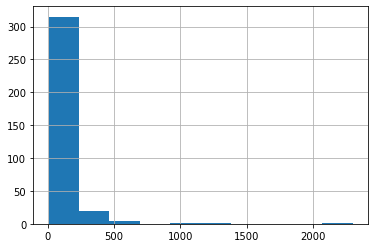

In [127]:
# What is the distribution of playlist's total tracks?
playlist_df['playlist_total_tracks'].hist()

<AxesSubplot:>

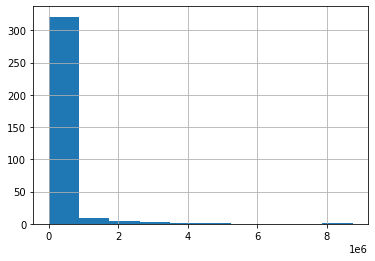

In [128]:
# What is the distribution of playlist's total tracks?
playlist_df['total_followers'].hist()

In [129]:
#tally of tracks
#tracks_df['genre'].value_counts()
tracks_df['genre'].value_counts(normalize=True)

rock      0.251592
folk      0.218934
hiphop    0.182268
indie     0.178731
rnb       0.168474
Name: genre, dtype: float64

### 2. Refine the training data

In [130]:
#get top 5 playlists per genre
top_playlists_df = playlist_df.groupby('genre').head(5)
top_playlists_df.head()

,playlist_id,playlist_name,playlist_total_tracks,owner_id,owner_name,total_followers,genre
0,37i9dQZF1DWXRqgorJj26U,Rock Classics,145,spotify,Spotify,8743130,rock
1,37i9dQZF1DXcF6B6QPhFDv,Rock This,50,spotify,Spotify,4490659,rock
2,37i9dQZF1DX1rVvRgjX59F,90s Rock Anthems,150,spotify,Spotify,4111532,rock
3,37i9dQZF1DWYN0zdqzbEwl,Rock en Español,60,spotify,Spotify,3829864,rock
4,37i9dQZF1DX3oM43CtKnRV,00s Rock Anthems,50,spotify,Spotify,3474724,rock


In [131]:
tracks_df = tracks_df[tracks_df['playlist_id'].isin(top_playlists_df['playlist_id'].values)]
tracks_df['genre'].value_counts()

rock      652
hiphop    622
folk      551
indie     385
rnb       283
Name: genre, dtype: int64

### 3. Feature Engineering

##### Conversions/Normalizations

In [132]:
#convert duration from ms to mins
tracks_df['duration_mins']=tracks_df['duration']/60000

In [133]:


tracks_df['loudness'] = scaler.fit_transform(tracks_df[['loudness']])
tracks_df['loudness'].describe()


count    2493.000000
mean        0.780520
std         0.092970
min         0.000000
25%         0.737415
50%         0.798792
75%         0.844682
max         1.000000
Name: loudness, dtype: float64

In [134]:
#Normalize tempo
tracks_df['tempo'] =  scaler.fit_transform(tracks_df[['tempo']])
#check
tracks_df['tempo'].describe()


count    2493.000000
mean        0.437393
std         0.179644
min         0.000000
25%         0.288169
50%         0.421637
75%         0.556355
max         1.000000
Name: tempo, dtype: float64

###### Categorical Encoding

In [135]:
tracks_df["genre"] = tracks_df["genre"].astype('category')
tracks_df.dtypes

track_id              object
track_name            object
artist_id             object
artist_name           object
album_id              object
duration               int64
release_date          object
popularity             int64
danceability         float64
energy               float64
key                    int64
loudness             float64
mode                   int64
speechiness          float64
acousticness         float64
instrumentalness     float64
liveness             float64
valence              float64
tempo                float64
playlist_id           object
genre               category
playlist_name         object
duration_mins        float64
dtype: object

In [136]:
tracks_df['genre'].value_counts()

rock      652
hiphop    622
folk      551
indie     385
rnb       283
Name: genre, dtype: int64

In [137]:
tracks_df['genre_id'] = tracks_df["genre"].cat.codes
tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,acousticness,instrumentalness,liveness,valence,tempo,playlist_id,genre,playlist_name,duration_mins,genre_id
0,0hCB0YR03f6AmQaHbwWDe8,Whole Lotta Love - 1990 Remaster,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,70lQYZtypdCALtFVlQAcvx,333893,1969-10-22,75,0.412,0.902,...,0.04840,0.131000,0.4050,0.422,0.256937,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,5.564883,4
1,2aoo2jlRnM3A0NyLQqMN2f,All Along the Watchtower,776Uo845nYHJpNaStv1Ds4,Jimi Hendrix,5z090LQztiqh13wYspQvKQ,240800,1968-10-25,76,0.438,0.805,...,0.00255,0.000057,0.0842,0.564,0.396949,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.013333,4
2,08mG3Y1vljYA6bvDt4Wqkj,Back In Black,711MCceyCBcFnzjGY4Q7Un,AC/DC,6mUdeDZCsExyJLMdAfDuwh,255493,1980-07-25,82,0.310,0.700,...,0.01100,0.009650,0.0828,0.763,0.844340,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.258217,4
3,1RJeiAIwR9pZBgJA8ndZLL,"Paint It, Black - Mono",22bE4uQ6baNwSHPVcDxLCe,The Rolling Stones,5nKpMsduwp5xqCKq2IbSKv,204480,1966-01-01,68,0.505,0.836,...,0.01030,0.077100,0.2950,0.764,0.673340,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,3.408000,4
4,66lOpKgTyFjOrac4S1s94g,Rebel Rebel - 1999 Remaster,0oSGxfWSnnOXhD2fKuz2Gy,David Bowie,6JxxRxzjsOTtKVie29FTt2,269360,1974-04-24,0,0.676,0.920,...,0.00101,0.000009,0.2480,0.624,0.474883,37i9dQZF1DWXRqgorJj26U,rock,Rock Classics,4.489333,4


In [138]:
genre_lookup = dict(tracks_df.groupby('genre_id').head(1)[['genre_id','genre']].values)
genre_lookup

{4: 'rock', 1: 'hiphop', 3: 'rnb', 0: 'folk', 2: 'indie'}

## 4. Train a KNN model

In [139]:
#test plot for a genre and 2 predictors

#fig = plt.figure()
#ax= fig.add_subplot(111)

#colormaps = ['Reds','Blues']
#genre = 'pop'
#label = ["not "+genre,genre]
#for n,genre_bool in enumerate([0,1]):
#    df=tracks_df[tracks_df['genre_'+genre]==genre_bool]
#    sns.kdeplot(df['energy'],df['tempo'], ax=ax,\
#                shade=True, shade_lowest=False, alpha=0.5, cmap=colormaps[n],\
#                label=label[n])
    
#plt.legend(frameon=False)


Tuning the model

In [162]:
#Select audio features to use for the model
feature_cols =  ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                'liveness',\
                'valence',\
                'tempo'\
                ]
results_optimal_k = []

kfolds= [4,5,8,10]
for col in feature_cols:
    if col != 'danceability':
        for d in kfolds:
            print('\nTuning kNN classification model with K-Fold=%d...' % d)
            # create feature matrix (X)
            duo = []
            duo.append(col)
            duo.append('danceability')
            X = tracks_df[duo]
            y = tracks_df['genre_id']
    
            # creating training set, test set and checking shapes 
            X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
            #print("Shape of X_Train:"+str(X_train.shape))
            #print("Shape of y_Train:"+str(Y_train.shape))
            #print("Shape of X_Test:"+str(X_test.shape))
            #print("Shape of y_Test:"+str(Y_test.shape))
            
            #train model
            cv_scores = []
            neighbors=np.arange(2,51)
            #print('Finding best k...')
            
            #Perform KNN using K= [1..50] and validate using k-fold k = 5
            for k in neighbors:
                #print('Fitting for k=%d' % k)
                knn = KNeighborsClassifier(n_neighbors=k)
                scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
                cv_scores.append(scores.mean())
            
            # changeto misclassification error
            mse = [1 - x for x in cv_scores]
        
            # determining best k
            optimal_k = neighbors[mse.index(min(mse))]
            results_optimal_k.append(optimal_k)
            
            knn_optimal = KNeighborsClassifier(n_neighbors=k)
            #knn_optimal.fit(X, y)
            # plot misclassification error vs k
            #plt.plot(neighbors, mse)
            #plt.xlabel("Number of Neighbors K")
            #plt.ylabel("Misclassification Error")
            #plt.show()
            
            print(col + " and danceability feature the optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))



Tuning kNN classification model with K-Fold=4...
energy and danceability feature the optimal number of neighbors is 37 with score 47%

Tuning kNN classification model with K-Fold=5...
energy and danceability feature the optimal number of neighbors is 48 with score 47%

Tuning kNN classification model with K-Fold=8...
energy and danceability feature the optimal number of neighbors is 40 with score 48%

Tuning kNN classification model with K-Fold=10...
energy and danceability feature the optimal number of neighbors is 35 with score 48%

Tuning kNN classification model with K-Fold=4...
loudness and danceability feature the optimal number of neighbors is 50 with score 44%

Tuning kNN classification model with K-Fold=5...
loudness and danceability feature the optimal number of neighbors is 47 with score 45%

Tuning kNN classification model with K-Fold=8...
loudness and danceability feature the optimal number of neighbors is 50 with score 46%

Tuning kNN classification model with K-Fold=10.

In [173]:
#Select audio features to use for the model
feature_cols =  ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
                ]
results_optimal_k = []

kfolds= [4,5,8,10]
for d in kfolds:
    print('\nTuning kNN classification model with K-Fold=%d...' % d)
    # create feature matrix (X)
    X = tracks_df[feature_cols]
    y = tracks_df['genre_id']

    # creating training set, test set and checking shapes 
    X_train,X_test,Y_train,Y_test = train_test_split(X,y, test_size=0.2)
    #print("Shape of X_Train:"+str(X_train.shape))
    #print("Shape of y_Train:"+str(Y_train.shape))
    #print("Shape of X_Test:"+str(X_test.shape))
    #print("Shape of y_Test:"+str(Y_test.shape))
    
    #train model
    cv_scores = []
    neighbors=np.arange(2,51)
    print('Finding best k...')
    
    #Perform KNN using K= [1..50] and validate using k-fold k = 5
    for k in neighbors:
        #print('Fitting for k=%d' % k)
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, Y_train, cv=d, scoring='accuracy')
        cv_scores.append(scores.mean())
        
    # changeto misclassification error
    mse = [1 - x for x in cv_scores]

    # determining best k
    optimal_k = neighbors[mse.index(min(mse))]
    results_optimal_k.append(optimal_k)
    
    knn_optimal = KNeighborsClassifier(n_neighbors=k)
    #knn_optimal.fit(X, y)
    # plot misclassification error vs k
    #plt.plot(neighbors, mse)
    #plt.xlabel("Number of Neighbors K")
    #plt.ylabel("Misclassification Error")
    #plt.show()
    
    print("The optimal number of neighbors is %d with score %d%%" % (optimal_k, 100*(1-min(mse))))



Tuning kNN classification model with K-Fold=4...
Finding best k...
The optimal number of neighbors is 49 with score 56%

Tuning kNN classification model with K-Fold=5...
Finding best k...
The optimal number of neighbors is 20 with score 56%

Tuning kNN classification model with K-Fold=8...
Finding best k...
The optimal number of neighbors is 40 with score 55%

Tuning kNN classification model with K-Fold=10...
Finding best k...
The optimal number of neighbors is 39 with score 56%


In [141]:
#results_optimal_k = [38, 33, 17, 21, 13, 46, 26, 27, 10, 26]
results_optimal_k

[50, 47, 50, 35]

### 5. Model Prediction

In [142]:
#Predict genres of the charting tracks
chart_tracks_df = pd.read_csv("data/spotify_daily_charts_tracks.csv")
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,0kN8xEmgMW9mh7UmDYHlJP,Versace on the Floor,0du5cEVh5yTK9QJze8zA0C,Bruno Mars,4PgleR09JVnm3zY1fW3XBA,261240,2016-11-17,76,0.578,0.574,2,-6.209,1,0.0454,0.196,0.00000,0.0830,0.301,174.152
1,5uCax9HTNlzGybIStD3vDh,Say You Won't Let Go,4IWBUUAFIplrNtaOHcJPRM,James Arthur,7oiJYvEJHsmYtrgviAVIBD,211466,2016-10-28,88,0.358,0.557,10,-7.398,1,0.0590,0.695,0.00000,0.0902,0.494,85.043
2,7BKLCZ1jbUBVqRi2FVlTVw,Closer,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0rSLgV8p5FzfnqlEk4GzxE,244960,2016-07-29,87,0.748,0.524,8,-5.599,1,0.0338,0.414,0.00000,0.1110,0.661,95.010
3,2rizacJSyD9S1IQUxUxnsK,All We Know,69GGBxA162lTqCwzJG5jLp,The Chainsmokers,0xmaV6EtJ4M3ebZUPRnhyb,194080,2016-09-29,71,0.662,0.586,0,-8.821,1,0.0307,0.097,0.00272,0.1150,0.296,90.000
4,5MFzQMkrl1FOOng9tq6R9r,Don't Wanna Know,04gDigrS5kc9YWfZHwBETP,Maroon 5,0fvTn3WXF39kQs9i3bnNpP,214480,2016-10-11,1,0.783,0.623,7,-6.126,1,0.0800,0.338,0.00000,0.0975,0.447,100.048


In [143]:
#normalize loudness and tempo
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])

Test the model with external data by predicting the genres of the spotify charting tracks!

In [175]:
#Predict genres of the spotify charts
feature_cols = ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
               ]
genres = [genre_lookup[i] for i in np.arange(len(genre_names))]

n=3 #pick kfold=10
print("Predicting with optimal k: %d" %(results_optimal_k[n]))

knn_optimal = KNeighborsClassifier(n_neighbors=results_optimal_k[n])
X = tracks_df[feature_cols]
y = tracks_df['genre_id']
knn_optimal.fit(X, y)

chart_tracks_df['predicted_genre_id'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict(x[feature_cols].values.reshape(1,-1))[0]\
                                               , axis=1)
chart_tracks_df['predicted_genre'] = chart_tracks_df['predicted_genre_id'].apply(lambda x: genre_lookup[x])
chart_tracks_df['predicted_genre_prob'] = chart_tracks_df.apply(lambda x:  np.max(knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1)))\
                                                    , axis=1)
chart_tracks_df['all_genre_prob'] = chart_tracks_df.apply(lambda x:  knn_optimal.predict_proba(x[feature_cols].values.reshape(1,-1))[0]\
                                                    , axis=1)


Predicting with optimal k: 39


In [176]:
#explode genre probabilities into separate columns
charts_predicted_genre_prob = pd.DataFrame(chart_tracks_df["all_genre_prob"].to_list(),
                                           columns=['predicted_'+g+'_prob' for g in genres])
charts_predicted_genre_prob['track_id'] = chart_tracks_df['track_id']
chart_tracks_df = pd.merge(chart_tracks_df,charts_predicted_genre_prob, how='left', on='track_id')
chart_tracks_df = chart_tracks_df.drop(columns='all_genre_prob')
chart_tracks_df = chart_tracks_df.sort_values('predicted_genre_prob', ascending=False)
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_folk_prob_x,predicted_hiphop_prob_x,predicted_indie_prob_x,predicted_rnb_prob_x,predicted_rock_prob_x,predicted_folk_prob_y,predicted_hiphop_prob_y,predicted_indie_prob_y,predicted_rnb_prob_y,predicted_rock_prob_y
35,4Km5HrUvYTaSUfiSGPJeQR,Bad and Boujee (feat. Lil Uzi Vert),6oMuImdp5ZcFhWP0ESe6mG,Migos,2AvupjUeMnSffKEV05x222,343150,2017-01-27,78,0.927,0.665,...,0.000000,0.885714,0.057143,0.028571,0.028571,0.0,0.974359,0.000000,0.025641,0.000000
982,2LTlO3NuNVN70lp2ZbVswF,FEEL.,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,4eLPsYPBmXABThSJ821sqY,214826,2017-04-14,66,0.746,0.798,...,0.114286,0.428571,0.114286,0.228571,0.114286,0.0,0.974359,0.000000,0.000000,0.025641
41,28FGV3ORH14MYORd7s5dlU,Not Alike (feat. Royce Da 5'9),7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,288086,2018-08-31,70,0.904,0.756,...,0.000000,0.857143,0.028571,0.085714,0.028571,0.0,0.974359,0.000000,0.000000,0.025641
593,2gsNpSn7VvvJuSrIDfRoYy,Kamikaze,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,216029,2018-08-31,70,0.780,0.808,...,0.057143,0.485714,0.171429,0.200000,0.085714,0.0,0.974359,0.000000,0.025641,0.000000
74,1jo3TwNGCXfNdB5uba3ZVv,Killshot,7dGJo4pcD2V6oG8kP0tJRR,Eminem,0RejlT9bmqcXGrqMaJRos0,253579,2018-09-19,75,0.893,0.651,...,0.000000,0.828571,0.028571,0.085714,0.057143,0.0,0.974359,0.025641,0.000000,0.000000


Check out tracks with highest assigned probability

In [177]:
chart_tracks_df.groupby('predicted_genre_id').head()[['artist_name','track_name','predicted_genre','predicted_genre_prob']]

,artist_name,track_name,predicted_genre,predicted_genre_prob
35,Migos,Bad and Boujee (feat. Lil Uzi Vert),hiphop,0.974359
982,Kendrick Lamar,FEEL.,hiphop,0.974359
41,Eminem,Not Alike (feat. Royce Da 5'9),hiphop,0.974359
593,Eminem,Kamikaze,hiphop,0.974359
74,Eminem,Killshot,hiphop,0.974359
1815,LANY,Dumb Stuff,rock,0.897436
1562,Queen,Radio Ga Ga - Live Aid,rock,0.897436
708,Kamikazee,Huling Sayaw,rock,0.897436
1021,Linkin Park,Somewhere I Belong,rock,0.897436
1612,Oasis,Wonderwall - Remastered,rock,0.871795


View histogram of predicted genre probabilities

<AxesSubplot:>

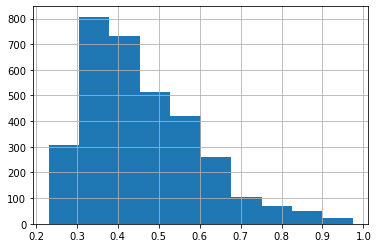

In [178]:
chart_tracks_df['predicted_genre_prob'].hist()

Check out tally of predicted genres

In [179]:
chart_tracks_df['predicted_genre'].value_counts()

rock      1135
folk      1049
hiphop     779
indie      208
rnb        113
Name: predicted_genre, dtype: int64

>Q **Spot Check**: Check out a song you're familiar with and see if the predicted genres and probabilities makes sense

In [180]:
this_song = 'SONG NAME HERE'
chart_tracks_df[chart_tracks_df['track_name']=='What is Love']

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_folk_prob_x,predicted_hiphop_prob_x,predicted_indie_prob_x,predicted_rnb_prob_x,predicted_rock_prob_x,predicted_folk_prob_y,predicted_hiphop_prob_y,predicted_indie_prob_y,predicted_rnb_prob_y,predicted_rock_prob_y
2356,1IX47gefluXmKX4PrTBCRM,What is Love,7n2Ycct7Beij7Dj7meI4X0,TWICE,35LVzMbjGUCfYZYEP6YWyr,208240,2018-07-09,75,0.574,0.909,...,0.342857,0.228571,0.057143,0.028571,0.342857,0.153846,0.051282,0.051282,0.051282,0.692308


In [181]:
#save data
chart_tracks_df.to_csv("data/spotify_daily_charts_tracks_predicted_genres.csv", index=False, encoding='utf-8')

## Part 2. Recommender Engine

In [186]:
#read data
chart_tracks_df=pd.read_csv("data/spotify_daily_charts_tracks_predicted_genres.csv")
#normalize loudness and tempo
scaler = MinMaxScaler()
chart_tracks_df['loudness'] = scaler.fit_transform(chart_tracks_df[['loudness']])
chart_tracks_df['tempo'] =  scaler.fit_transform(chart_tracks_df[['tempo']])
chart_tracks_df.head()

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_folk_prob_x,predicted_hiphop_prob_x,predicted_indie_prob_x,predicted_rnb_prob_x,predicted_rock_prob_x,predicted_folk_prob_y,predicted_hiphop_prob_y,predicted_indie_prob_y,predicted_rnb_prob_y,predicted_rock_prob_y
0,4Km5HrUvYTaSUfiSGPJeQR,Bad and Boujee (feat. Lil Uzi Vert),6oMuImdp5ZcFhWP0ESe6mG,Migos,2AvupjUeMnSffKEV05x222,343150,2017-01-27,78,0.927,0.665,...,0.000000,0.885714,0.057143,0.028571,0.028571,0.0,0.974359,0.000000,0.025641,0.000000
1,2LTlO3NuNVN70lp2ZbVswF,FEEL.,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,4eLPsYPBmXABThSJ821sqY,214826,2017-04-14,66,0.746,0.798,...,0.114286,0.428571,0.114286,0.228571,0.114286,0.0,0.974359,0.000000,0.000000,0.025641
2,28FGV3ORH14MYORd7s5dlU,Not Alike (feat. Royce Da 5'9),7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,288086,2018-08-31,70,0.904,0.756,...,0.000000,0.857143,0.028571,0.085714,0.028571,0.0,0.974359,0.000000,0.000000,0.025641
3,2gsNpSn7VvvJuSrIDfRoYy,Kamikaze,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,216029,2018-08-31,70,0.780,0.808,...,0.057143,0.485714,0.171429,0.200000,0.085714,0.0,0.974359,0.000000,0.025641,0.000000
4,1jo3TwNGCXfNdB5uba3ZVv,Killshot,7dGJo4pcD2V6oG8kP0tJRR,Eminem,0RejlT9bmqcXGrqMaJRos0,253579,2018-09-19,75,0.893,0.651,...,0.000000,0.828571,0.028571,0.085714,0.057143,0.0,0.974359,0.025641,0.000000,0.000000


In [187]:
# Input seed track here
seed_track_name = "Harana"

In [188]:
feature_cols = ['danceability',\
                'energy',\
                'loudness',\
                'speechiness',\
                'acousticness',\
                'instrumentalness',\
                #'liveness',\
                'valence',\
                'tempo'\
               ]

In [189]:
seed_track_data = chart_tracks_df[chart_tracks_df['track_name']==seed_track_name].iloc[0]
seed_track_data[feature_cols]

danceability        0.580000
energy              0.159000
loudness            0.088557
speechiness         0.056900
acousticness        0.792000
instrumentalness    0.000001
valence             0.424000
tempo               0.608222
Name: 650, dtype: object

In [190]:
#compute cosine distances, audio features only
chart_tracks_df['cosine_dist'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[feature_cols].values.reshape(1, -1),\
                                                                  seed_track_data[feature_cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
chart_tracks_df

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,...,predicted_hiphop_prob_x,predicted_indie_prob_x,predicted_rnb_prob_x,predicted_rock_prob_x,predicted_folk_prob_y,predicted_hiphop_prob_y,predicted_indie_prob_y,predicted_rnb_prob_y,predicted_rock_prob_y,cosine_dist
0,4Km5HrUvYTaSUfiSGPJeQR,Bad and Boujee (feat. Lil Uzi Vert),6oMuImdp5ZcFhWP0ESe6mG,Migos,2AvupjUeMnSffKEV05x222,343150,2017-01-27,78,0.927,0.665,...,0.885714,0.057143,0.028571,0.028571,0.000000,0.974359,0.000000,0.025641,0.000000,0.390420
1,2LTlO3NuNVN70lp2ZbVswF,FEEL.,2YZyLoL8N0Wb9xBt1NhZWg,Kendrick Lamar,4eLPsYPBmXABThSJ821sqY,214826,2017-04-14,66,0.746,0.798,...,0.428571,0.114286,0.228571,0.114286,0.000000,0.974359,0.000000,0.000000,0.025641,0.350965
2,28FGV3ORH14MYORd7s5dlU,Not Alike (feat. Royce Da 5'9),7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,288086,2018-08-31,70,0.904,0.756,...,0.857143,0.028571,0.085714,0.028571,0.000000,0.974359,0.000000,0.000000,0.025641,0.371102
3,2gsNpSn7VvvJuSrIDfRoYy,Kamikaze,7dGJo4pcD2V6oG8kP0tJRR,Eminem,3HNnxK7NgLXbDoxRZxNWiR,216029,2018-08-31,70,0.780,0.808,...,0.485714,0.171429,0.200000,0.085714,0.000000,0.974359,0.000000,0.025641,0.000000,0.426963
4,1jo3TwNGCXfNdB5uba3ZVv,Killshot,7dGJo4pcD2V6oG8kP0tJRR,Eminem,0RejlT9bmqcXGrqMaJRos0,253579,2018-09-19,75,0.893,0.651,...,0.828571,0.028571,0.085714,0.057143,0.000000,0.974359,0.025641,0.000000,0.000000,0.339257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3279,1Hu42ZLWG9dHaVOPiWyEmE,Beautiful Scars,2Q9c6ETFOkDDTy53U7DIgr,Maximillian,1mTP6AfzT0v0eaihtcXOxe,194757,2020-10-23,76,0.706,0.457,...,0.371429,0.171429,0.285714,0.114286,0.179487,0.205128,0.205128,0.230769,0.179487,0.175747
3280,6xRNqXP3baPR9buXr8vreM,3AM,1z7b1Pr1rSlvWRzsW3HOrS,Russ,5Vmz3pIxG7Dsx7fzHgtyJB,200547,2020-05-19,72,0.569,0.657,...,0.200000,0.142857,0.142857,0.171429,0.179487,0.230769,0.205128,0.179487,0.205128,0.503117
3281,6u7gmPOz7pzzaeR9xSBpsR,my hair,66CXWjxzNUsdJxJ2JdwvnR,Ariana Grande,3euz4vS7ezKGnNSwgyvKcd,158436,2020-10-30,79,0.686,0.526,...,0.371429,0.085714,0.200000,0.200000,0.205128,0.230769,0.179487,0.153846,0.230769,0.390727
3282,7iNMzfw2couNdTNXMYG2IR,Filipina Girl,43CiK1548VVp2DT95joswS,Billy Crawford,0bBU7EKITlqetuEdnRHepO,218133,2019-03-22,54,0.570,0.463,...,0.171429,0.171429,0.085714,0.228571,0.230769,0.128205,0.230769,0.230769,0.179487,0.156511


In [191]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']].sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
531,Parallel Universe,Clara Benin,0.033998,folk,0.534,0.025,0.220716,0.0374,0.581,0.000020,0.179,0.503667
253,Girls Like You - Acoustic,Matt Johnson,0.038448,folk,0.535,0.104,0.470379,0.1060,0.932,0.000000,0.522,0.694102
569,nobody else,LANY,0.040844,folk,0.569,0.291,0.398813,0.0430,0.744,0.000000,0.313,0.609699
969,hoax,Taylor Swift,0.041710,folk,0.662,0.181,0.376049,0.0415,0.966,0.000004,0.429,0.407629
1009,hoax,Taylor Swift,0.041710,folk,0.662,0.181,0.376049,0.0415,0.966,0.000004,0.429,0.407629
287,peace,Taylor Swift,0.042256,folk,0.647,0.272,0.464442,0.0916,0.918,0.000017,0.339,0.599761
1004,I Will Be Here (Original Soundtrack from the m...,Alessandra De Rossi,0.042764,folk,0.426,0.203,0.287329,0.0313,0.902,0.082600,0.221,0.747905
824,Jingle Bells (with The Ken Lane Singers),Frank Sinatra,0.045785,folk,0.542,0.156,0.405159,0.0287,0.866,0.000000,0.692,0.521431
954,Our First Song,Joseph Vincent,0.046336,folk,0.701,0.252,0.548864,0.0477,0.958,0.000011,0.723,0.649251
2064,Pangga,Matthaios,0.048581,folk,0.765,0.437,0.475742,0.0730,0.861,0.000000,0.535,0.599743


In [192]:
#get top 10 nearest to seed_track_data
recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\
                                    [chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                    .sort_values('cosine_dist')[:10]
recommendation_df[['track_name','artist_name','cosine_dist','predicted_genre']+feature_cols]

<ipython-input-192-3525b1bc5e04>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  recommendation_df = chart_tracks_df[chart_tracks_df['predicted_genre']==seed_track_data['predicted_genre']]\


,track_name,artist_name,cosine_dist,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,valence,tempo
531,Parallel Universe,Clara Benin,0.033998,folk,0.534,0.025,0.220716,0.0374,0.581,0.000020,0.179,0.503667
253,Girls Like You - Acoustic,Matt Johnson,0.038448,folk,0.535,0.104,0.470379,0.1060,0.932,0.000000,0.522,0.694102
569,nobody else,LANY,0.040844,folk,0.569,0.291,0.398813,0.0430,0.744,0.000000,0.313,0.609699
969,hoax,Taylor Swift,0.041710,folk,0.662,0.181,0.376049,0.0415,0.966,0.000004,0.429,0.407629
1009,hoax,Taylor Swift,0.041710,folk,0.662,0.181,0.376049,0.0415,0.966,0.000004,0.429,0.407629
287,peace,Taylor Swift,0.042256,folk,0.647,0.272,0.464442,0.0916,0.918,0.000017,0.339,0.599761
1004,I Will Be Here (Original Soundtrack from the m...,Alessandra De Rossi,0.042764,folk,0.426,0.203,0.287329,0.0313,0.902,0.082600,0.221,0.747905
824,Jingle Bells (with The Ken Lane Singers),Frank Sinatra,0.045785,folk,0.542,0.156,0.405159,0.0287,0.866,0.000000,0.692,0.521431
954,Our First Song,Joseph Vincent,0.046336,folk,0.701,0.252,0.548864,0.0477,0.958,0.000011,0.723,0.649251
2064,Pangga,Matthaios,0.048581,folk,0.765,0.437,0.475742,0.0730,0.861,0.000000,0.535,0.599743


In [193]:
#Audio features + predicted genre probabilities
genre_cols = [col for col in chart_tracks_df.columns if ('predicted_' in col)&('genre' not in col)]
cols = feature_cols + genre_cols
chart_tracks_df['cosine_dist_mod'] = chart_tracks_df.apply(lambda x: 1-cosine_similarity(x[cols].values.reshape(1, -1),\
                                                                  seed_track_data[cols].values.reshape(1, -1))\
                                                                  .flatten()[0], axis=1)
recommendation_df = chart_tracks_df[chart_tracks_df['track_id']!=seed_track_data['track_id']]\
                                   .sort_values('cosine_dist_mod')[:10]
recommendation_df[['track_name','artist_name','cosine_dist_mod','predicted_genre']+cols]

,track_name,artist_name,cosine_dist_mod,predicted_genre,danceability,energy,loudness,speechiness,acousticness,instrumentalness,...,predicted_folk_prob_x,predicted_hiphop_prob_x,predicted_indie_prob_x,predicted_rnb_prob_x,predicted_rock_prob_x,predicted_folk_prob_y,predicted_hiphop_prob_y,predicted_indie_prob_y,predicted_rnb_prob_y,predicted_rock_prob_y
531,Parallel Universe,Clara Benin,0.032942,folk,0.534,0.025,0.220716,0.0374,0.581,0.000020,...,0.285714,0.142857,0.114286,0.057143,0.400000,0.589744,0.000000,0.282051,0.076923,0.051282
253,Girls Like You - Acoustic,Matt Johnson,0.036481,folk,0.535,0.104,0.470379,0.1060,0.932,0.000000,...,0.314286,0.200000,0.114286,0.000000,0.371429,0.666667,0.000000,0.333333,0.000000,0.000000
824,Jingle Bells (with The Ken Lane Singers),Frank Sinatra,0.038840,folk,0.542,0.156,0.405159,0.0287,0.866,0.000000,...,0.171429,0.142857,0.228571,0.085714,0.371429,0.538462,0.025641,0.358974,0.025641,0.051282
1057,Iris,Kina Grannis,0.042367,folk,0.497,0.130,0.355333,0.0436,0.841,0.000000,...,0.314286,0.114286,0.085714,0.057143,0.428571,0.512821,0.000000,0.461538,0.000000,0.025641
969,hoax,Taylor Swift,0.044498,folk,0.662,0.181,0.376049,0.0415,0.966,0.000004,...,0.257143,0.142857,0.200000,0.142857,0.257143,0.512821,0.000000,0.461538,0.000000,0.025641
1009,hoax,Taylor Swift,0.044498,folk,0.662,0.181,0.376049,0.0415,0.966,0.000004,...,0.257143,0.142857,0.200000,0.142857,0.257143,0.512821,0.000000,0.461538,0.000000,0.025641
1004,I Will Be Here (Original Soundtrack from the m...,Alessandra De Rossi,0.044881,folk,0.426,0.203,0.287329,0.0313,0.902,0.082600,...,0.400000,0.028571,0.171429,0.028571,0.371429,0.512821,0.000000,0.487179,0.000000,0.000000
559,Let It Snow! Let It Snow! Let It Snow!,Dean Martin,0.046643,folk,0.451,0.240,0.419079,0.0351,0.912,0.000002,...,0.228571,0.057143,0.171429,0.114286,0.428571,0.589744,0.000000,0.282051,0.051282,0.076923
464,When a Child Is Born,Jose Mari Chan,0.049187,folk,0.497,0.346,0.402334,0.0298,0.751,0.002720,...,0.314286,0.114286,0.085714,0.057143,0.428571,0.615385,0.000000,0.307692,0.051282,0.025641
449,Something There,Emma Watson,0.049649,folk,0.450,0.317,0.466489,0.0381,0.896,0.000051,...,0.228571,0.057143,0.171429,0.142857,0.400000,0.615385,0.000000,0.358974,0.000000,0.025641
